Q(r) gives Surface Density
------------------------------

We find that
$$
    \Sigma_g = \left[\frac{\sqrt{2} M f_g}{\pi G Q_g} \sqrt{\frac{G M(<r)}{r^3}}\right]^{5/4}
$$
Now, let's plot it.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Constants setup!

In [2]:
G = 4.302e-6  # msun yr km/s
fg = 0.1
f = 0.4
F = 0.5
Pf = 300000
Qmarg = 1  # marginally stable

#disk
M_disk = 8e9
R_disk = 3

#Nfw
R = 16.1
M_halo = 1.53e12
c = 20.1

#derived
mart_pref = 1.8 * (f/F)**(3/5) * G**(2/5) * Pf**(1/5) * fg**(-2/5)
sigma_0 = M_disk/(2*np.pi*R_disk**2)

In [3]:
def m_nfw(r):
    norm = M_halo/(np.log(1+c) - c/(1+c))
    return (np.log((r + R)/R) - r/(r+R))*norm

In [4]:
def sig_g(r, Q=Qmarg):
    this_pref = (np.sqrt(2) * mart_pref * fg)/(np.pi * G * Q)
    v = np.sqrt(G * m_nfw(r)/(r**3))
    return (this_pref * v)**(5/4)

It would also be good to plot the expected variation with $r$ for a regular disk (i.e. an exponential profile)

In [5]:
def exp_profile(r):
    return sigma_0 * (np.exp(-r/R_disk))

<IPython.core.display.Javascript object>


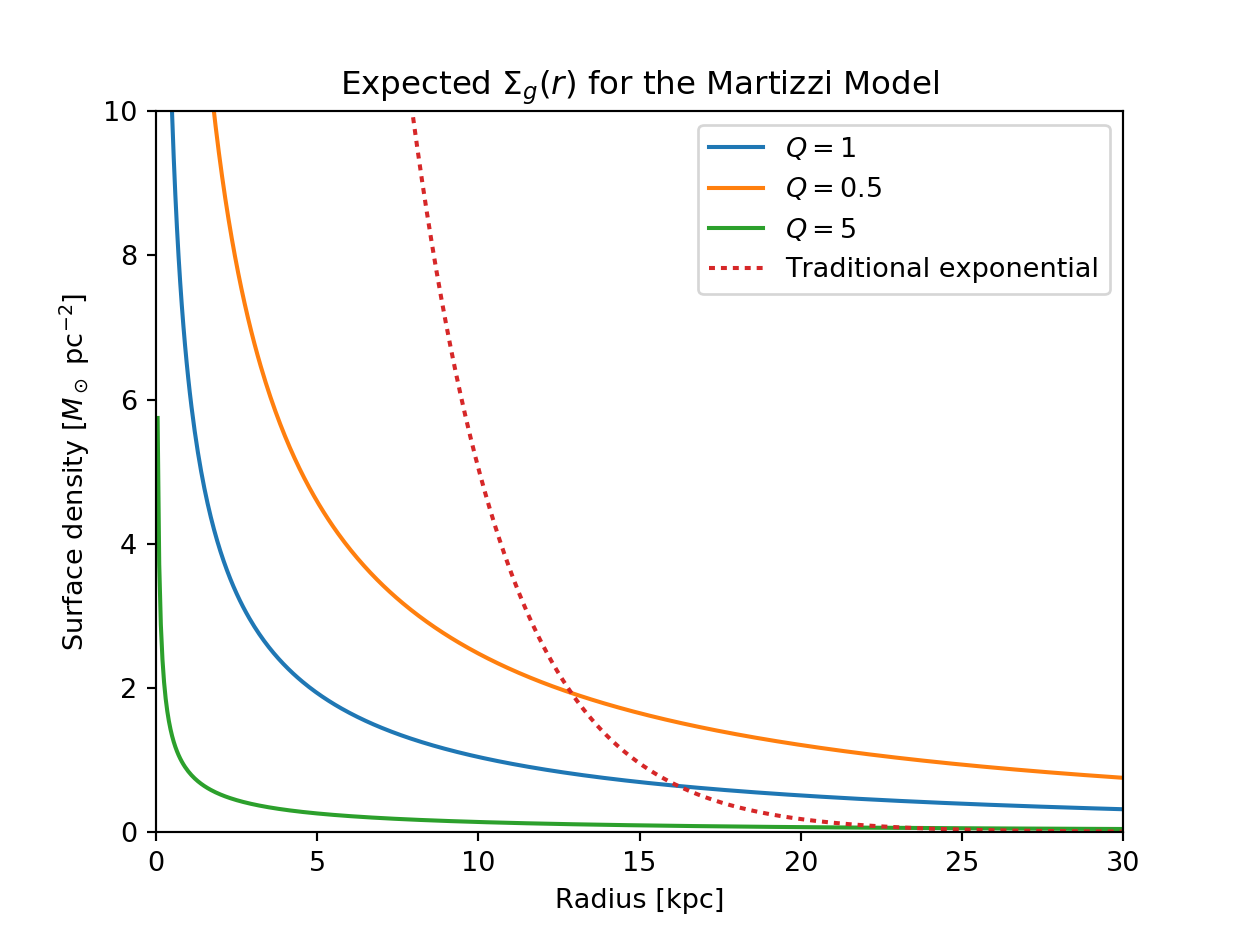

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [19]:
fig, ax = plt.subplots()

r = np.arange(0, 30, 0.05)
sg_1 = sig_g(r, 1)
sg_05 = sig_g(r, 0.5)
sg_5 = sig_g(r, 5)
ax.plot(r, sg_1/1e6, label=r"$Q = 1$")
ax.plot(r, sg_05/1e6, label=r"$Q = 0.5$")
ax.plot(r, sg_5/1e6, label=r"$Q = 5$")
ax.plot(r, exp_profile(r)/1e6, label=r"Traditional exponential", ls="dotted")


ax.set_ylim(0, 10)
ax.set_xlim(0, 30)
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel("Surface density [$M_\odot$ pc$^{-2}$]")
ax.set_title("Expected $\Sigma_g(r)$ for the Martizzi Model")
plt.legend()


Okay, but this clearly predicts a stable mass for the disk. I wonder what that is?

We will need to numerically solve
$$
    \mathrm{d}M = \Sigma_g(r) \cdot (2\pi r) \cdot \mathrm{d}r
$$

In [7]:
def integrand(r, Q=1):
    return (2 * np.pi * r) * (sig_g(r, Q))

In [8]:
from scipy.integrate import quad
from decimal import Decimal

In [9]:
for thisQ in [0.5, 1, 5]:
    mass = quad(integrand, 0, 100, args=(thisQ))[0]
    print("The mass is {:.2E} for a Toomre Q of {}".format(Decimal(mass), thisQ))

The mass is 1.23E+10 for a Toomre Q of 0.5
The mass is 5.19E+9 for a Toomre Q of 1
The mass is 6.94E+8 for a Toomre Q of 5


So interestingly we see that **the stable mass within 100 kpc is of order the disk mass that we see in real life!** This is somewhat limited, though, as we don't really consider interactions with the stellar disk and they should 'play off' each other.

Now let's take a look at the actual data.

In [10]:
import survis

In [11]:
fname = "stable_gal.hdf5"
res_elem = 1
bbox = [-30, 30]
res = survis.helper.get_res(res_elem, bbox, bbox)
data_grid = survis.preprocess.DataGridder(fname, res[0], res[1], bbox[0], bbox[1], bbox[0], bbox[1])

In [12]:
sd_actual = survis.helper.sd_r(data_grid, res_elem, 30)
#sd_actual needs cleaning
sd_actual = np.array([np.array(x) for x in sd_actual])

<IPython.core.display.Javascript object>


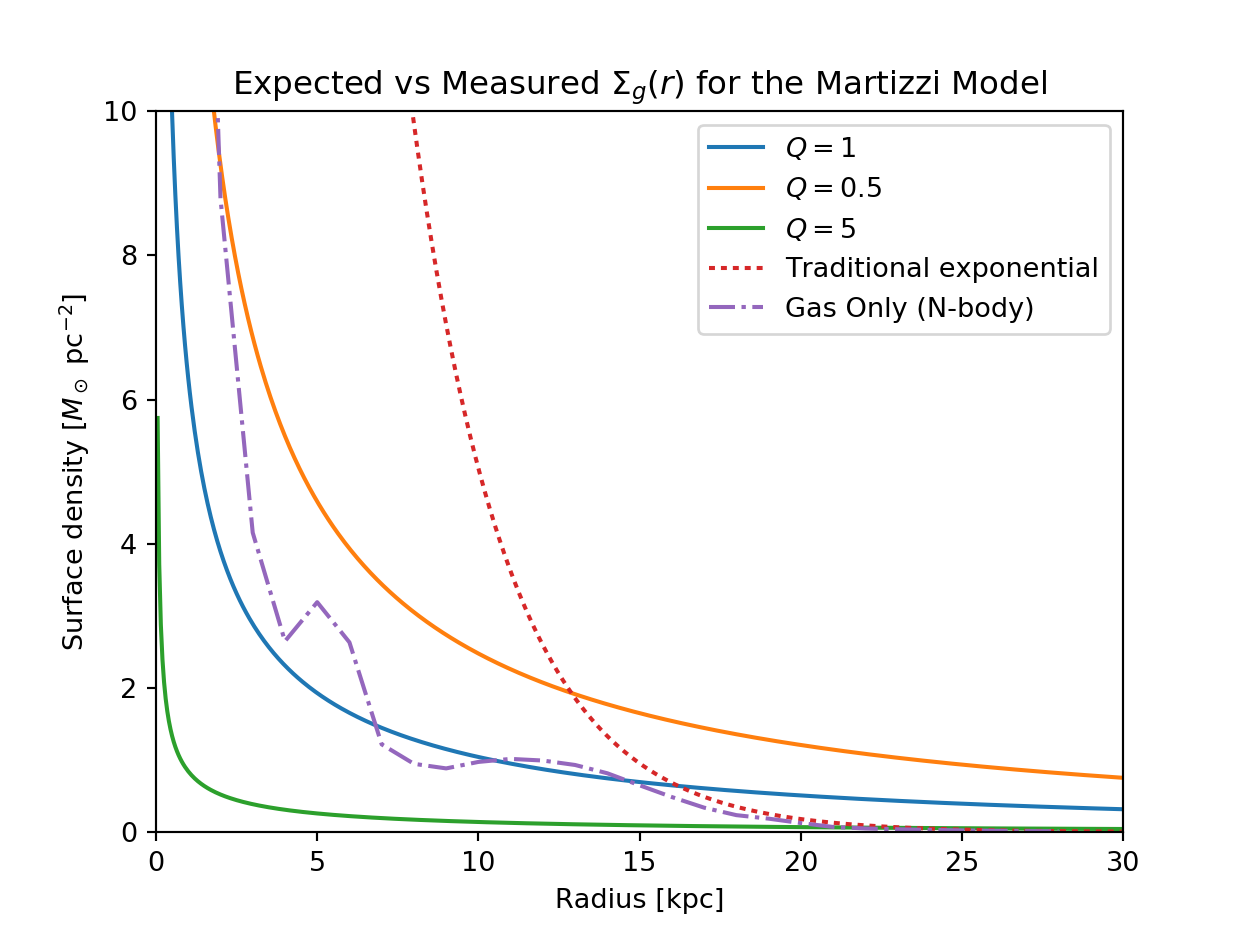

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [18]:
fig, ax = plt.subplots()

r = np.arange(0, 30, 0.05)
sg_1 = sig_g(r, 1)
sg_05 = sig_g(r, 0.5)
sg_5 = sig_g(r, 5)
ax.plot(r, sg_1/1e6, label=r"$Q = 1$")
ax.plot(r, sg_05/1e6, label=r"$Q = 0.5$")
ax.plot(r, sg_5/1e6, label=r"$Q = 5$")
ax.plot(r, exp_profile(r)/1e6, label=r"Traditional exponential", ls="dotted")

plt.plot(np.arange(len(sd_actual[:, 0])), sd_actual[:, 0]/1e6, label="Gas Only (N-body)", ls="-.")

ax.set_ylim(0, 10)
ax.set_xlim(0, 30)
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel("Surface density [$M_\odot$ pc$^{-2}$]")
plt.title("Expected vs Measured $\Sigma_g(r)$ for the Martizzi Model")

plt.legend()